# Import Libraries

In [1]:
import os, sys, json, cv2, time, glob, gc, datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.model_selection import train_test_split
from kerastuner import HyperModel, Hyperband
from kerastuner.tuners import RandomSearch
from keras.layers import BatchNormalization

/var/folders/nv/cddx4y_s46n_4yhxp7v2bb540000gn/T/ipykernel_37550/422802593.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, Hyperband


# Configurations

In [2]:
# Setup the paths to train and test images
TRAIN_DIR = './global-wheat-detection/train/'
TEST_DIR = './global-wheat-detection/test/'
TRAIN_CSV_PATH = './global-wheat-detection/train.csv'
AUG_SAVE_DIR = './global-wheat-detection/augmented_images/'
SAVE_PATH = 'models/CustomCNN/'
CHECKPOINT_DIR = 'models/CustomCNN/checkpoints/'

EPOCHS = 20
IMG_SIZE = 256

# Create a directory if it doesn't exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# Data Loading

In [3]:
df = pd.read_csv('./df_augment.csv')[:10]
# df = pd.read_csv('./df_full.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image_id  10 non-null     object 
 1   x         10 non-null     float64
 2   y         10 non-null     float64
 3   w         10 non-null     float64
 4   h         10 non-null     float64
 5   source    10 non-null     object 
dtypes: float64(4), object(2)
memory usage: 612.0+ bytes


In [4]:
def load_image_and_bbox(image_id, bbox):
    image = tf.io.read_file(image_id)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    bbox = bbox / IMG_SIZE
    return image, bbox

def parse_dataframe(df, TRAIN_DIR=TRAIN_DIR, AUG_SAVE_DIR=AUG_SAVE_DIR):
    image_ids = []
    for i, row in tqdm(df.iterrows(), total=len(df), desc='Parsing dataframe and image path'):
        image_id = row['image_id']
        ori_image_path = f'{TRAIN_DIR}/{image_id}.jpg'
        augmented_image_path = f'{AUG_SAVE_DIR}/{image_id}.jpg'
        if os.path.exists(ori_image_path):
            image_path = ori_image_path
        else:
            image_path = augmented_image_path
        image_ids.append(image_path)
    bboxes = df[['x', 'y', 'w', 'h']].values
    return image_ids, bboxes

def create_dataset(image_paths, bboxes, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, bboxes))
    dataset = dataset.map(lambda x, y: load_image_and_bbox(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

image_ids, bboxes = parse_dataframe(df)


Parsing dataframe and image path:   0%|          | 0/10 [00:00<?, ?it/s]

Parsing dataframe and image path: 100%|██████████| 10/10 [00:00<00:00, 5076.62it/s]


In [5]:
# Split the dataset
train_paths, test_paths, train_bboxes, test_bboxes = train_test_split(image_ids, bboxes, test_size=0.4, random_state=42)
test_paths, val_paths, test_bboxes, val_bboxes = train_test_split(test_paths, test_bboxes, test_size=0.5, random_state=42)

# Create TensorFlow Datasets
train_dataset = create_dataset(train_paths, train_bboxes)
val_dataset = create_dataset(val_paths, val_bboxes)
test_dataset = create_dataset(test_paths, test_bboxes)

train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))


In [6]:
for images, bboxes in train_dataset.take(1):
    print(images.shape, bboxes.shape, len(train_dataset))
for images, bboxes in test_dataset.take(1):
    print(images.shape, bboxes.shape, len(test_dataset))
for images, bboxes in val_dataset.take(1):
    print(images.shape, bboxes.shape, len(val_dataset))

(6, 256, 256, 3) (6, 4) 1
(2, 256, 256, 3) (2, 4) 1
(2, 256, 256, 3) (2, 4) 1


# Model building

In [7]:
def plot_metrics(history):
    # Extract metrics from the history object
    accuracy = history.history.get('accuracy', [])
    val_accuracy = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    mae = history.history.get('mae', [])
    val_mae = history.history.get('val_mae', [])
    mse = history.history.get('mse', [])  # Add this line
    val_mse = history.history.get('val_mse', [])  # Add this line
    rmse = history.history.get('rmse', [])
    val_rmse = history.history.get('val_rmse', [])
    learning_rate = history.history.get('lr', [])

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 3, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation MAE values
    plt.subplot(2, 3, 3)
    plt.plot(mae)
    plt.plot(val_mae)
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation MSE values
    plt.subplot(2, 3, 4)
    plt.plot(mse)
    plt.plot(val_mse)
    plt.title('Model MSE')  # Add this line
    plt.ylabel('MSE')  # Add this line
    plt.xlabel('Epoch')  # Add this line
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot learning rate
    if learning_rate:
        plt.subplot(2, 3, 5)
        plt.plot(learning_rate)
        plt.title('Learning Rate')
        plt.ylabel('Learning Rate')
        plt.xlabel('Epoch')

    plt.tight_layout()
    plt.show()

## Custom CNN 1

In [8]:
class CustomCNNModel1:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu'))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(4, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
        return model

    def compile_model(self):
        self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model1.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN1', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        lr_scheduler = LearningRateScheduler(self.step_decay_schedule(initial_lr=0.1, decay_factor=0.5, step_size=10))
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, lr_scheduler, checkpoint_callback, tensorboard_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, acc, mse, mae, rmse = results
        # rmse = np.sqrt(mse)
        lr = self.model.optimizer.learning_rate.numpy()
        print(f'Testing Loss: {loss:.4f}, Accuracy: {acc:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, Learning Rate: {lr:.4f}')
        return {
            'loss': loss,
            'accuracy': acc,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'learning_rate': lr
        }
        
    def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
        def schedule(epoch):
            return initial_lr * (decay_factor ** (epoch // step_size))
        return schedule
    
    def save_model(self, path):
        self.model.save(path)

# Initialize the CustomCNNModel class
custom_cnn_model1 = CustomCNNModel1(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model1.compile_model()

custom_cnn_model1.model.summary()

Using device: /GPU:0


/Users/byron/opt/anaconda3/envs/ODLG4/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,348 (630.27 KB)

 Trainable params: 161,348 (630.27 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = custom_cnn_model1.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model1.evaluate(test_dataset)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1667 - loss: 256.7752 - mae: 12.6744 - mse: 256.7752 - rmse: 16.0242 - val_accuracy: 0.0000e+00 - val_loss: 2200985927680.0000 - val_mae: 1215618.7500 - val_mse: 2200985927680.0000 - val_rmse: 1483572.0000 - learning_rate: 0.1000
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.1667 - loss: 2266308542464.0000 - mae: 1236066.6250 - mse: 2266308542464.0000 - rmse: 1505426.3750 - val_accuracy: 0.0000e+00 - val_loss: 132948464.0000 - val_mae: 11210.1865 - val_mse: 132948464.0000 - val_rmse: 11530.3281 - learning_rate: 0.1000
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.0000e+00 - loss: 124446488.0000 - mae: 10574.6445 - mse: 124446488.0000 - rmse: 11155.5586 - val_accuracy: 0.0000e+00 - val_loss: 95.8380 - val_mae: 9.5752 - val_mse: 95.8380 - val_rmse: 9.7897 - learning_rate: 0.1000
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.0000e+00 - loss: 69.6878 - mae: 7.9841 - mse: 69.68

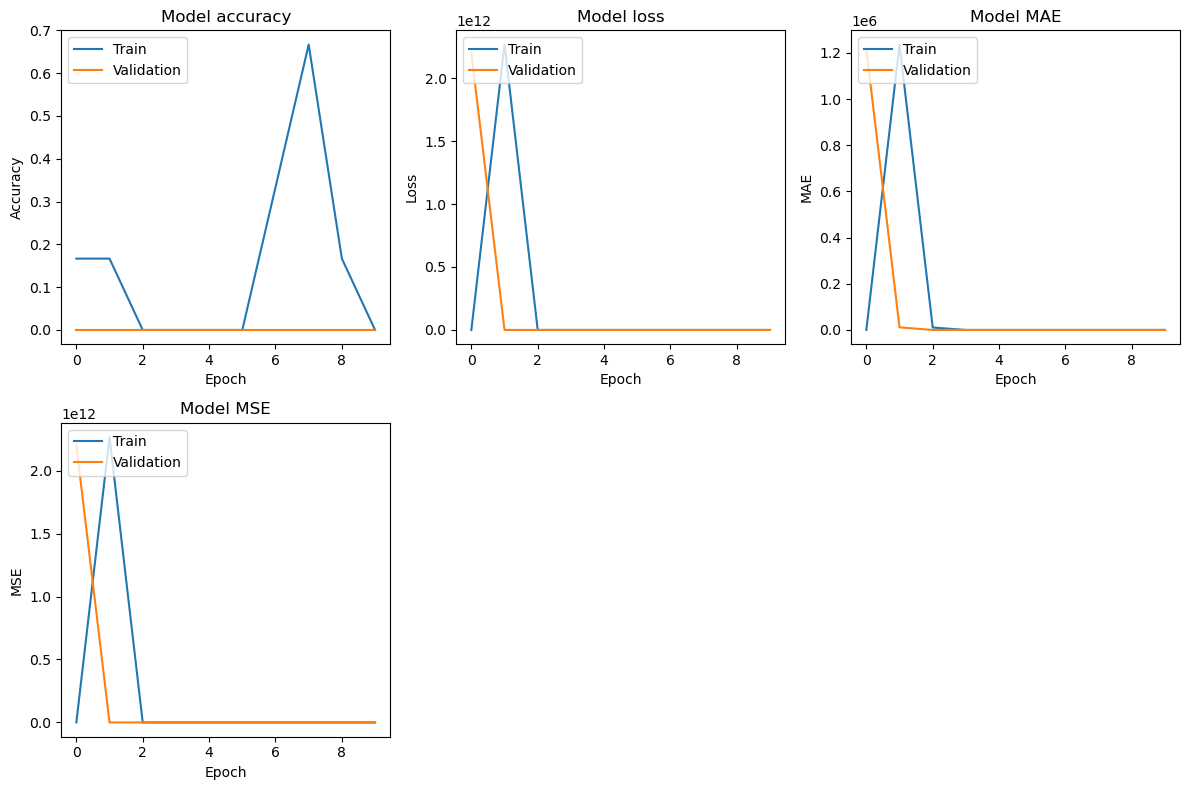

In [10]:
plot_metrics(history)

In [11]:
# Save the entire model
custom_cnn_model1.save(SAVE_PATH + 'custom_cnn_model1.keras')

AttributeError: 'CustomCNNModel1' object has no attribute 'save'

In [ ]:
# Load the model from a file
# custom_cnn_model1 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model1.keras')
gc.collect()

## Custom CNN 2

In [16]:
class CustomCNNModel2:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Fourth Convolutional Block
            model.add(Conv2D(256, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu'))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(4, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
        return model

    def compile_model(self):
        self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model2.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN2', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        lr_scheduler = LearningRateScheduler(self.step_decay_schedule(initial_lr=0.1, decay_factor=0.5, step_size=10))
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, lr_scheduler, checkpoint_callback, tensorboard_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, acc, mse, mae, rmse = results
        # rmse = np.sqrt(mse)
        lr = self.model.optimizer.learning_rate.numpy()
        print(f'Testing Loss: {loss:.4f}, Accuracy: {acc:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, Learning Rate: {lr:.4f}')
        return {
            'loss': loss,
            'accuracy': acc,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'learning_rate': lr
        }
    
    def save(self, path):
        self.model.save(path)

    def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
        def schedule(epoch):
            return initial_lr * (decay_factor ** (epoch // step_size))
        return schedule

# Initialize the CustomCNNModel class
custom_cnn_model2 = CustomCNNModel2(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model2.compile_model()

custom_cnn_model2.model.summary()

Using device: /GPU:0


/Users/byron/opt/anaconda3/envs/ODLG4/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,052 (1.99 MB)

 Trainable params: 522,052 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the model
history2 = custom_cnn_model2.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model2.evaluate(test_dataset)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 190.4945 - mae: 11.9863 - mse: 190.4945 - rmse: 13.8020 - val_accuracy: 0.0000e+00 - val_loss: 22578767629123584.0000 - val_mae: 147371168.0000 - val_mse: 22578767629123584.0000 - val_rmse: 150262336.0000 - learning_rate: 0.1000
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.0000e+00 - loss: 24724196135272448.0000 - mae: 154280592.0000 - mse: 24724196135272448.0000 - rmse: 157239296.0000 - val_accuracy: 0.0000e+00 - val_loss: 4830601216.0000 - val_mae: 69331.9219 - val_mse: 4830601216.0000 - val_rmse: 69502.5234 - learning_rate: 0.1000
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.3333 - loss: 4838089216.0000 - mae: 68581.4766 - mse: 4838089216.0000 - rmse: 69556.3750 - val_accuracy: 0.0000e+00 - val_loss: 122055.4688 - val_mae: 319.5618 - val_mse: 122055.4688 - val_rmse: 349.3644 - learning_rate: 0.1000
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.1667 - loss

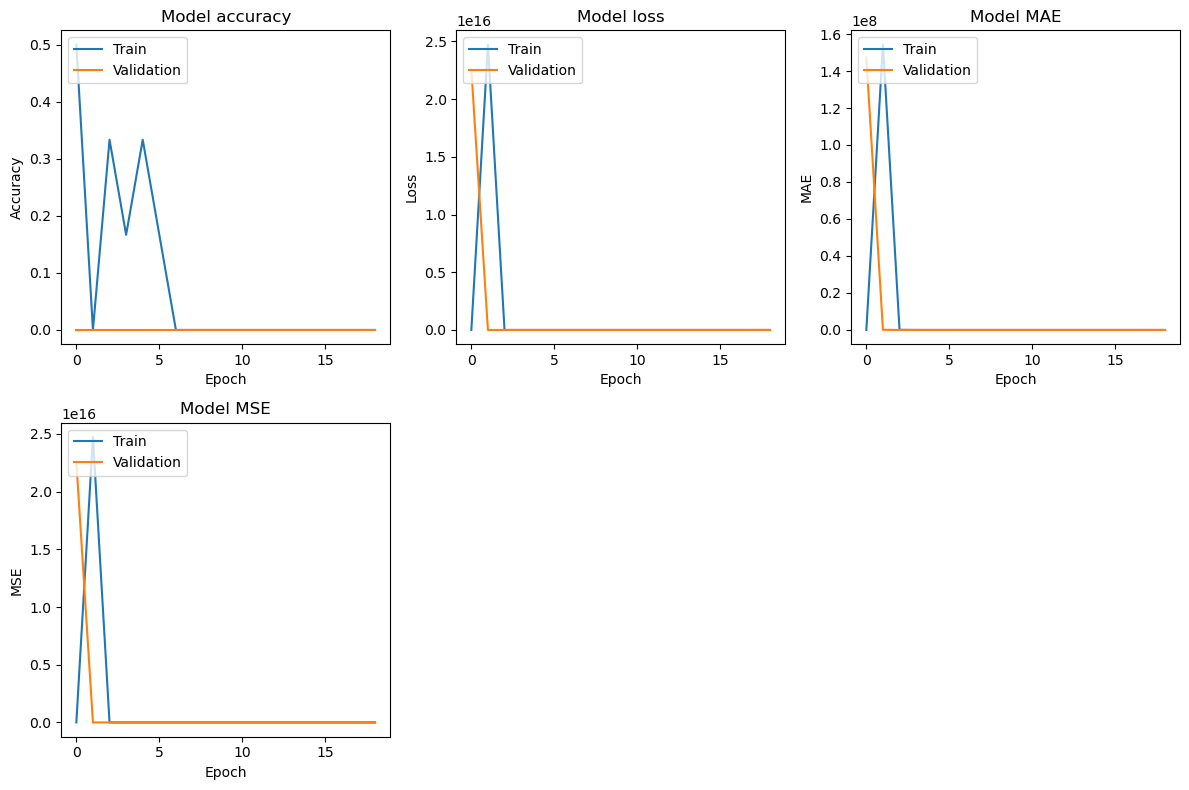

In [18]:
plot_metrics(history2)

In [19]:
# Save the entire model
custom_cnn_model2.save(SAVE_PATH + 'custom_cnn_model2.keras')

In [20]:
# Load the model from a file
# custom_cnn_model2 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model2.keras')
gc.collect()

37167

## Custom CNN 3

In [23]:
class CustomCNNModel3:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Fourth Convolutional Block
            model.add(Conv2D(256, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Fifth Convolutional Block
            model.add(Conv2D(512, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(4, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
        return model

    def compile_model(self):
        self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model3.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN3', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        lr_scheduler = LearningRateScheduler(self.step_decay_schedule(initial_lr=0.1, decay_factor=0.5, step_size=10))
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, lr_scheduler, checkpoint_callback, tensorboard_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, acc, mse, mae, rmse = results
        # rmse = np.sqrt(mse)
        lr = self.model.optimizer.learning_rate.numpy()
        print(f'Testing Loss: {loss:.4f}, Accuracy: {acc:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, Learning Rate: {lr:.4f}')
        return {
            'loss': loss,
            'accuracy': acc,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'learning_rate': lr
        }
    
    def save(self, path):
        self.model.save(path)
        
    def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
        def schedule(epoch):
            return initial_lr * (decay_factor ** (epoch // step_size))
        return schedule

# Initialize the CustomCNNModel class
custom_cnn_model3 = CustomCNNModel3(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model3.compile_model()

custom_cnn_model3.model.summary()

Using device: /GPU:0


/Users/byron/opt/anaconda3/envs/ODLG4/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,837,252 (7.01 MB)

 Trainable params: 1,835,268 (7.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [24]:
# Train the model
history3 = custom_cnn_model3.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model3.evaluate(test_dataset)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.3333 - loss: 2.3610 - mae: 1.1996 - mse: 1.8470 - rmse: 1.3590 - val_accuracy: 0.0000e+00 - val_loss: 136634377248440320.0000 - val_mae: 345708448.0000 - val_mse: 136634377248440320.0000 - val_rmse: 369640864.0000 - learning_rate: 0.1000
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1667 - loss: 77225.4219 - mae: 259.2978 - mse: 77223.3672 - rmse: 277.8909 - val_accuracy: 1.0000 - val_loss: 1222710525952.0000 - val_mae: 1078234.6250 - val_mse: 1222710525952.0000 - val_rmse: 1105762.3750 - learning_rate: 0.1000
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step - accuracy: 0.3333 - loss: 4694.6606 - mae: 67.4480 - mse: 4691.0996 - rmse: 68.4916 - val_accuracy: 0.0000e+00 - val_loss: 113283235840.0000 - val_mae: 245717.1250 - val_mse: 113283235840.0000 - val_rmse: 336575.7500 - learning_rate: 0.1000
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step - accuracy: 0.0000e+00 - loss: 133.4975 - mae: 9.1154 - mse: 127.5

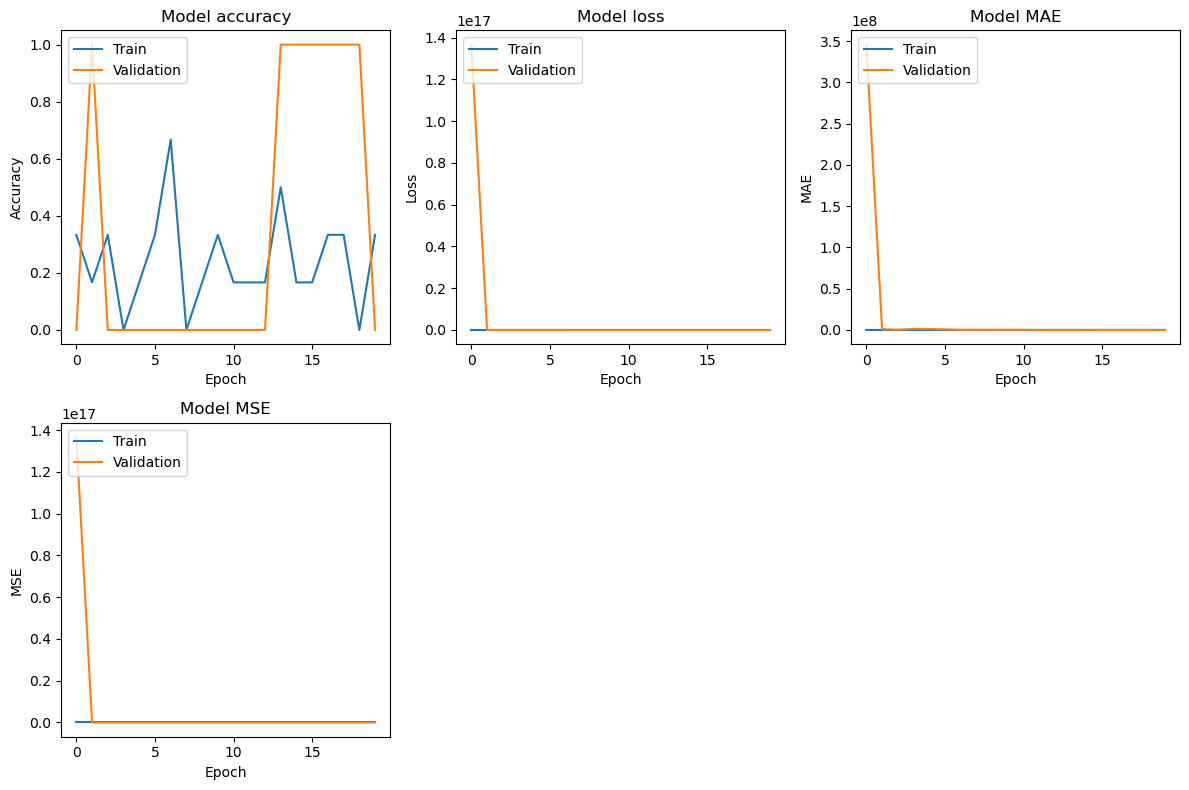

In [25]:
plot_metrics(history3)

In [26]:
# Save the entire model
custom_cnn_model3.save(SAVE_PATH + 'custom_cnn_model3.keras')

In [27]:
# Load the model from a file
# custom_cnn_model3 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model3.keras')
gc.collect()

20354

# Hyperparameter tuning for Custom CNN 3

In [29]:
class CustomCNNHyperModel(HyperModel):
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32), 
                         (3, 3), activation=hp.Choice('conv_1_activation', values=['relu', 'sigmoid']), 
                         input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Second Convolutional Block
        model.add(Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=256, step=64), 
                         (3, 3), activation=hp.Choice('conv_2_activation', values=['relu', 'sigmoid']))),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Third Convolutional Block
        model.add(Conv2D(hp.Int('conv_3_filters', min_value=128, max_value=512, step=128), 
                         (3, 3), activation=hp.Choice('conv_3_activation', values=['relu', 'sigmoid']))),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Fourth Convolutional Block
        model.add(Conv2D(hp.Int('conv_4_filters', min_value=256, max_value=1024, step=256), 
                         (3, 3), activation=hp.Choice('conv_4_activation', values=['relu', 'sigmoid']))),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Fifth Convolutional Block
        model.add(Conv2D(hp.Int('conv_5_filters', min_value=512, max_value=2048, step=512), 
                         (3, 3), activation=hp.Choice('conv_5_activation', values=['relu', 'sigmoid']))),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Global Average Pooling instead of Flattening
        model.add(GlobalAveragePooling2D())

        # Fully Connected Layer with Dropout
        model.add(Dense(hp.Int('dense_units', min_value=256, max_value=1024, step=256), 
                        activation=hp.Choice('dense_activation', values=['relu', 'sigmoid']), kernel_regularizer=l2(0.001))),
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

        # Output Layer
        model.add(Dense(4, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)

        # Compile the model
        optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        if optimizer == 'adam':
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                                  loss='mse')
        elif optimizer == 'rmsprop':
            model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate),
                                  loss='mse')
        elif optimizer == 'sgd':
            model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
                                  loss='mse')
        return model
    
    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        print(results)
        loss, acc, mse, mae, rmse = results
        # rmse = np.sqrt(mse)
        lr = self.model.optimizer.learning_rate.numpy()
        print(f'Testing Loss: {loss:.4f}, Accuracy: {acc:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, Learning Rate: {lr:.4f}')
        return {
            'loss': loss,
            'accuracy': acc,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'learning_rate': lr
        }
    
    def save(self, path):
        self.model.save(path)

# Initialize the hypermodel
hypermodel = CustomCNNHyperModel(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Initialize the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_loss',
    max_epochs=EPOCHS,  
    factor=3, 
    directory='hyperparameter_tuning',
    project_name='custom_cnn_model',
    overwrite=True
)

# Display search space summary
tuner.search_space_summary()

# Run the hyperparameter search
tuner.search(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
best_model.evaluate(test_dataset)

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

# Retrieve the best activation function and optimizer
best_activation = best_hyperparameters.get('conv_1_activation')
best_activation_2 = best_hyperparameters.get('conv_2_activation')
best_activation_3 = best_hyperparameters.get('conv_3_activation')
best_activation_4 = best_hyperparameters.get('conv_4_activation')
best_activation_5 = best_hyperparameters.get('conv_5_activation')
best_conv1_value = best_hyperparameters.get('conv_1_filters')
best_conv2_value = best_hyperparameters.get('conv_2_filters')
best_conv3_value = best_hyperparameters.get('conv_3_filters')
best_conv4_value = best_hyperparameters.get('conv_4_filters')
best_conv5_value = best_hyperparameters.get('conv_5_filters')
best_optimizer = best_hyperparameters.get('optimizer')

print(f"Best activation function: {best_activation}")
print(f"Best optimizer: {best_optimizer}")


Trial 2 Complete [00h 00m 05s]
val_loss: 2484.27197265625

Best val_loss So Far: 70.53460693359375
Total elapsed time: 00h 00m 14s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 75.9012
{'conv_1_filters': 128, 'conv_1_activation': 'relu', 'conv_2_filters': 128, 'conv_2_activation': 'sigmoid', 'conv_3_filters': 384, 'conv_3_activation': 'sigmoid', 'conv_4_filters': 1024, 'conv_4_activation': 'relu', 'conv_5_filters': 512, 'conv_5_activation': 'sigmoid', 'dense_units': 1024, 'dense_activation': 'sigmoid', 'dropout_rate': 0.4, 'optimizer': 'adam', 'learning_rate': 0.008961015644502074, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Best activation function: relu
Best optimizer: adam


In [30]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)

best_model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

# Train the model on the full dataset
history_best = best_model.fit(train_dataset, epochs=EPOCHS, batch_size=32, validation_data=val_dataset)

# Evaluate the best model
best_model.evaluate(test_dataset)

Epoch 1/20


/Users/byron/opt/anaconda3/envs/ODLG4/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1667 - loss: 2.4193 - mae: 1.0067 - mse: 1.7381 - rmse: 1.3184 - val_accuracy: 1.0000 - val_loss: 2.0082 - val_mae: 0.7808 - val_mse: 1.3269 - val_rmse: 1.1519
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step - accuracy: 0.8333 - loss: 2.9353 - mae: 1.2317 - mse: 2.2540 - rmse: 1.5013 - val_accuracy: 1.0000 - val_loss: 1.9674 - val_mae: 0.8065 - val_mse: 1.2865 - val_rmse: 1.1342
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step - accuracy: 0.5000 - loss: 1.1442 - mae: 0.5655 - mse: 0.4633 - rmse: 0.6806 - val_accuracy: 1.0000 - val_loss: 1.6149 - val_mae: 0.7182 - val_mse: 0.9344 - val_rmse: 0.9666
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step - accuracy: 0.3333 - loss: 1.1217 - mae: 0.5630 - mse: 0.4412 - rmse: 0.6642 - val_accuracy: 1.0000 - val_loss: 1.3224 - val_mae: 0.6180 - val_mse: 0.6424 - val_rmse: 0.8015
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step - accuracy: 0.1667 - loss: 1.1027 - mae: 0.4983 - mse: 0.4227 - rmse

[1.748619794845581,
 0.5,
 0.7256323099136353,
 1.083677053451538,
 1.040998101234436]

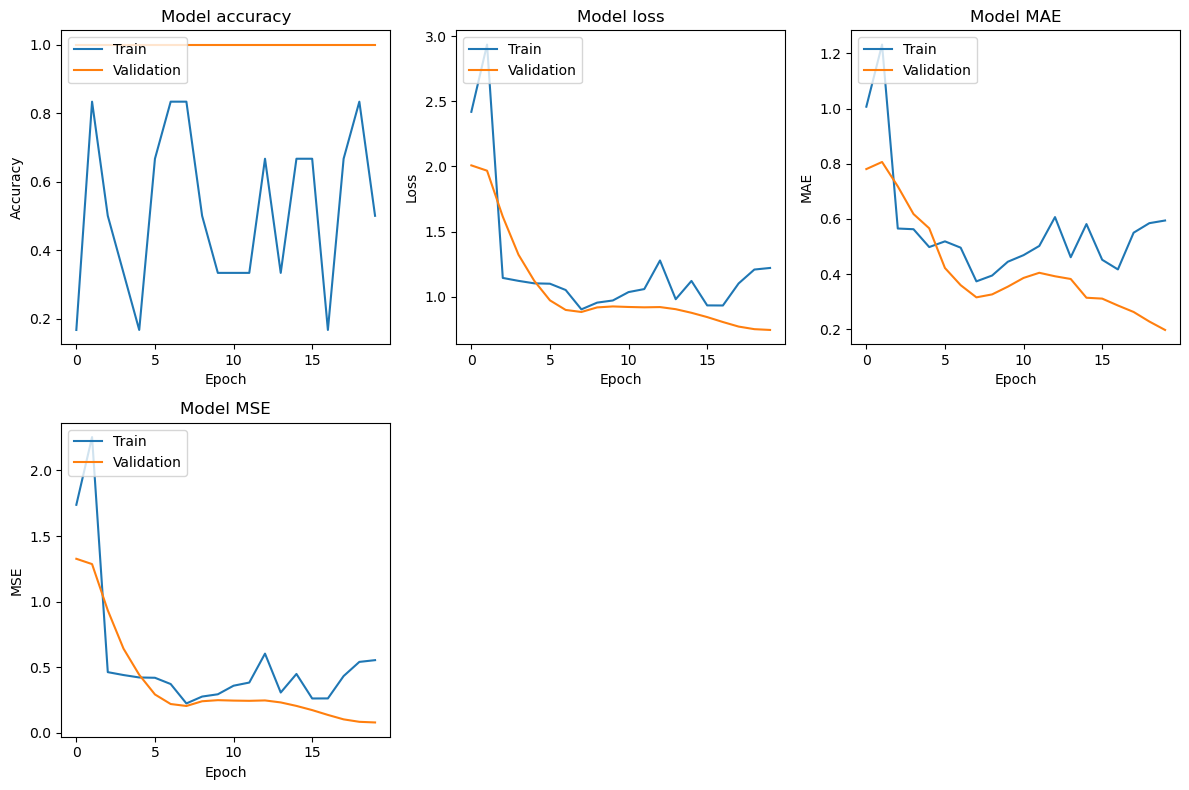

In [31]:
plot_metrics(history_best)

In [32]:
best_model.save(SAVE_PATH + 'best_custom_cnn_model.keras')